In [2]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import lightning_models as mp

class ModelClass(pl.LightningModule):
    def __init__(self, model: str = 'resnet18', num_classes: int = 3):
        super().__init__()

        if model == 'resnet50':
            self.model = mp.ResNet50(num_classes=num_classes)
        elif model == 'vit':
            self.model = mp.VisionTransformerBase(num_classes=num_classes)
        elif model == 'vit_tiny':
            self.model = mp.VisionTransformerTiny(num_classes=num_classes)
        elif model == 'swinv2_base':
            self.model = mp.SwinV2Base(num_classes=num_classes)
        elif model == 'mobilenetv3_large':
            self.model = mp.MobileNetV3Large(num_classes=num_classes)
        elif model == 'resnet18':
            self.model = mp.ResNet18(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

In [46]:
model_ckpt = 'weights/classify/vit_tiny.ckpt'

model = ModelClass(model='vit_tiny')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

checkpoint = torch.load(model_ckpt, map_location=device)
model_state_dict = model.state_dict()
# common_state_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_state_dict}

model.load_state_dict(model_state_dict, strict=False)

<All keys matched successfully>

In [47]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image

class Transform:
    def __init__(self):
        self.transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(),
            ToTensorV2()
        ])
        
    def __call__(self, image):
        return self.transform(image=image)['image']

In [48]:
def infer(img_path) -> int:
    img_np = np.array(Image.open(img_path).convert('RGB'))
    img = Transform()(image=img_np)

    model.eval()
    with torch.no_grad():
        output = model(img.unsqueeze(0))

    return torch.argmax(output, dim=1).item()

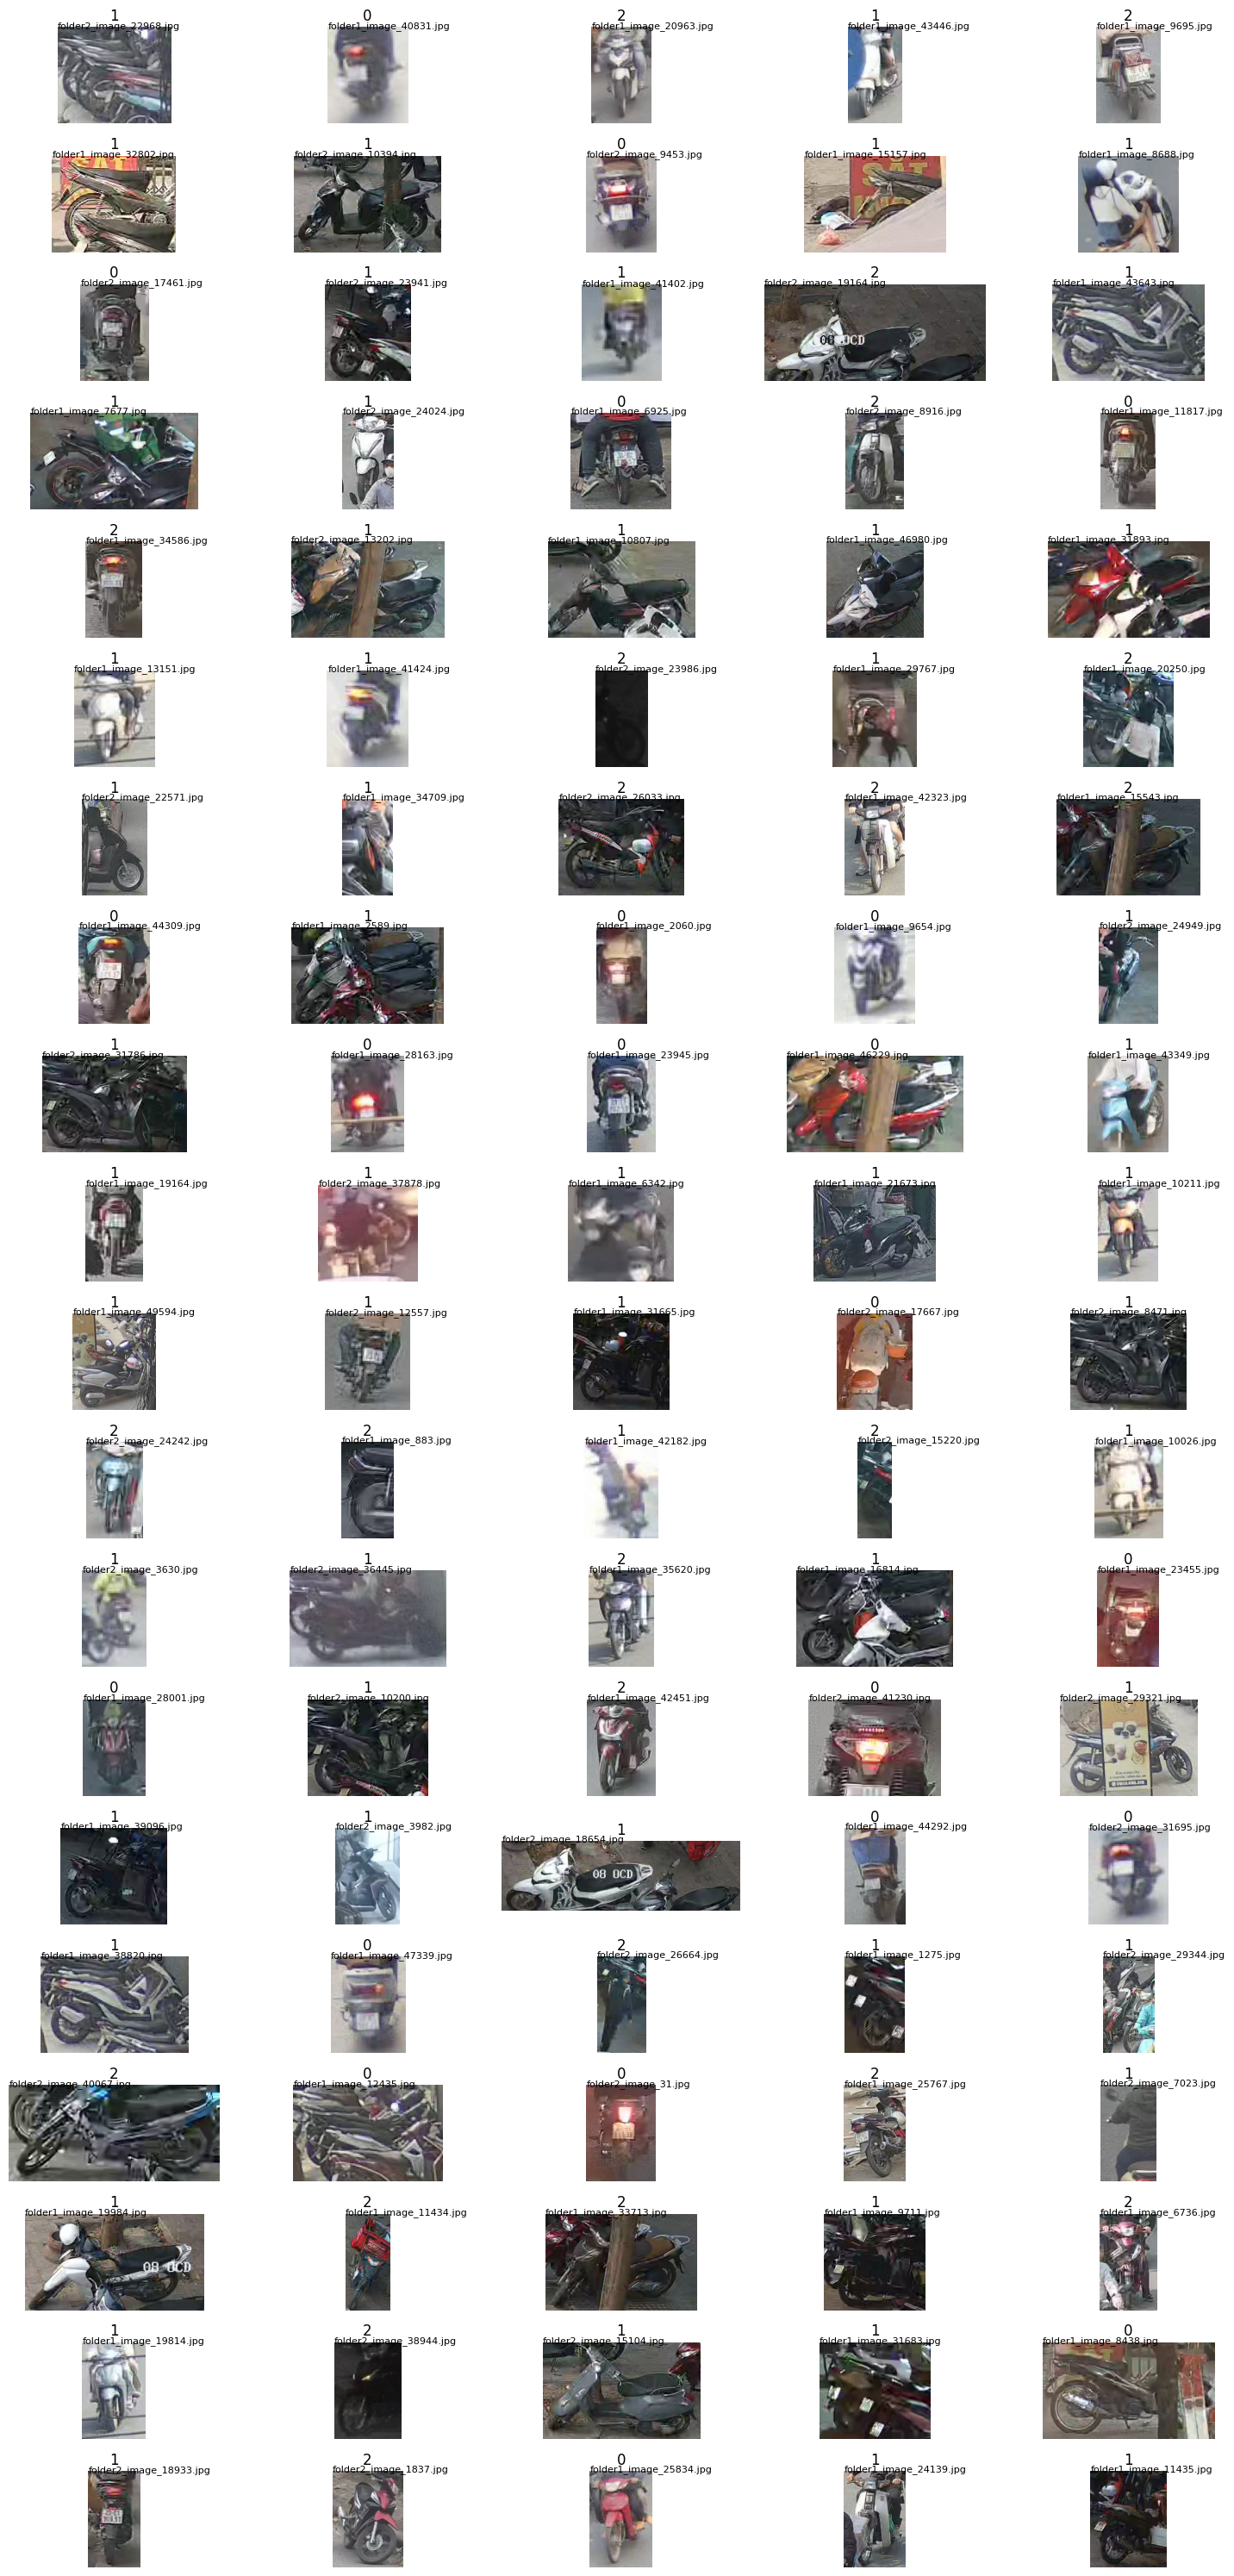

In [49]:
# crops = 'runs/detect/predict/crops/motorcycle'
crops = r'D:\Data Deep Learning\FINAL-DATASET\FINAL-DATASET\train\valid\images'
import os

img_paths = [os.path.join(crops, img) for img in os.listdir(crops)]

# Randomly sample 10 images
import random
img_paths = random.sample(img_paths, 100)

# Infer and plot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axs = plt.subplots(20, 5, figsize=(15, 30))
for i, img_path in enumerate(img_paths):
    img = mpimg.imread(img_path)
    # Plot the image name
    axs[i//5, i%5].text(0, 0, img_path.split('\\')[-1], fontsize=8)
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(infer(img_path))
    axs[i//5, i%5].axis('off')

plt.tight_layout()
plt.show()